### Instructions
This notebook runs all the modelling and saves them as pickle files
IMPORTANT: Make sure you have pandas >= 1.5.0 in order to read in the pickle files

1. Run first cell and function definition cells

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

features_all = pd.read_csv('features_all_weeks.csv')
features_all.drop(columns = ['Unnamed: 0', 'X'], inplace = True)
# display(features_all)
print(features_all.info())

unclean_train_df = features_all[features_all['week'] != 8]
unclean_test_df = features_all[features_all['week'] == 8]

unclean_train_df.drop(columns = ['week'], inplace = True)
unclean_test_df.drop(columns = ['week'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274529 entries, 0 to 274528
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   playId                 274529 non-null  int64  
 1   gameId                 274529 non-null  int64  
 2   frameId                274529 non-null  int64  
 3   area_block             274529 non-null  float64
 4   dist_block             274529 non-null  float64
 5   dist_to_qb_block       274529 non-null  float64
 6   x_force_block          274529 non-null  float64
 7   y_force_block          274529 non-null  float64
 8   norm_weighted_x_block  274529 non-null  float64
 9   norm_weighted_y_block  274529 non-null  float64
 10  area_rush              274529 non-null  float64
 11  dist_rush              274529 non-null  float64
 12  dist_to_qb_rush        274529 non-null  float64
 13  x_force_rush           274529 non-null  float64
 14  y_force_rush           274529 non-nu

C:\Users\Harrison\AppData\Local\Temp\ipykernel_19708\3812691315.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclean_train_df.drop(columns = ['week'], inplace = True)
C:\Users\Harrison\AppData\Local\Temp\ipykernel_19708\3812691315.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclean_test_df.drop(columns = ['week'], inplace = True)


In [3]:
def get_features(df, features = 'all', response = 'bad_thing'):
    """
    Gets relevant features depending on what we want to use for modelling.
    There are 2 types of features: distance features and force features. 
    Force features can also be decomposed to simple forces, weighted forces, and partitioned forces
    TODO: missing net forces
    """
    y = df['bad_thing']
    x = df.drop(columns = ['bad_thing', 'hit', 'hurry', 'sack', 'playId', 'gameId', 'frameId'])
    if features == 'all':
        return (x, y)
    elif features == 'distance':
        x = x[['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush']]
    
    elif features == 'force_simple':
        x = x[['x_force_block', 'y_force_block', 'x_force_rush', 'y_force_rush']]
    
    elif features == 'force_weighted':
        x = x[['norm_weighted_x_block', 'norm_weighted_y_block', 'norm_weighted_x_rush', 'norm_weighted_y_rush']]
    
    elif features == 'force_partitioned':
        x = x[['net_x_force_bottom', 'net_y_force_bottom', 'net_x_force_middle', 'net_y_force_middle', 
               'net_x_force_top', 'net_y_force_top']]
    elif features == 'force_all':
        x = x.drop(columns = ['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush'])
    
    return (x, y)

# keep track of frameID
def df_split_by_frame(df, group_by = 5, features = 'all'):
    """
    Helper function to get separate dataframes for each frameID. Also keeps track of which set of features we're using
    for naming the model later on
    """
    df_grouped = df.groupby('frameId')
    df_dict = dict()

    for n, df in df_grouped:
        if (n % group_by == 1 and n < 60):
            x, y = get_features(df, features)
            # display(x)
            df_dict[n] = (x, y, features)
            # df_list.append((n, x, y))
    return df_dict

In [24]:
def train_rf_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models[frameID] = (rf, features_str)
        del rf
    pickle.dump(models, open(f"model_list_rf_{features_str}.pkl", "wb"))
    return models

def train_lr_model(df_list):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models[frameID] = (rf, features_str)
        del rf
    pickle.dump(models, open(f"model_list_rf_{features_str}.pkl", "wb"))
    return models

def evaluate(test_df_dict, models):
    p_results, r_results = [], []
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        precision = precision_score(y, pred)
        
        print(f'{frameID}: Out-of-bag score estimate: {model.oob_score_:.3}')
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        p_results.append(accuracy)
        r_results.append(recall)
        
        
        
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC ')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        print(f'len: {len(p)}')
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        # ConfusionMatrixDisplay(confusion_matrix(y, pred)).plot()
    return p_results, r_results
        


In [11]:
features = 'force_all'

clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))

models = train_rf_model(clean_train_df_dict)
# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

1
6
11
16
21
26
31
36
41
46
51
56


In [12]:
models_force_simple = pickle.load(open("model_list_rf_force_simple.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_force_simple.pkl", "rb"))

models_force_dist = pickle.load(open("model_list_rf_distance.pkl", "rb"))
clean_test_df_dict_dist = pickle.load(open("clean_test_dict_distance.pkl", "rb"))

models_force_weighted = pickle.load(open("model_list_rf_force_weighted.pkl", "rb"))
clean_test_df_dict_force_weighted = pickle.load(open("clean_test_dict_force_weighted.pkl", "rb"))

models_force_partitioned = pickle.load(open("model_list_rf_force_partitioned.pkl", "rb"))
clean_test_df_dict_force_partitioned = pickle.load(open("clean_test_dict_force_partitioned.pkl", "rb"))

models_force_all = pickle.load(open("model_list_rf_force_all.pkl", "rb"))
clean_test_df_dict_force_all = pickle.load(open("clean_test_dict_force_all.pkl", "rb"))

models_all = pickle.load(open("model_list_rf_all.pkl", "rb"))
clean_test_df_dict_all = pickle.load(open("clean_test_dict_all.pkl", "rb"))

1: Out-of-bag score estimate: 0.617
1: Mean accuracy score: 0.609
1: Recall: 0.0386


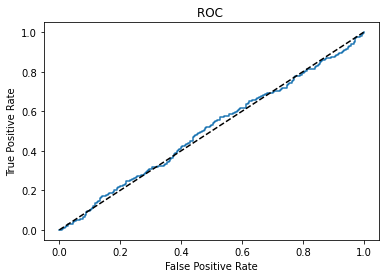

len: 1032


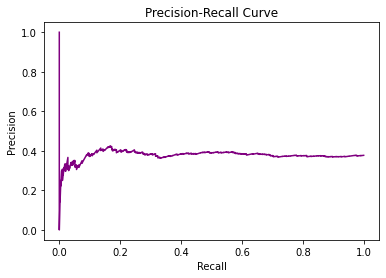

6: Out-of-bag score estimate: 0.616
6: Mean accuracy score: 0.612
6: Recall: 0.054


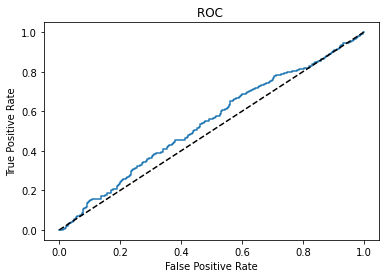

len: 1032


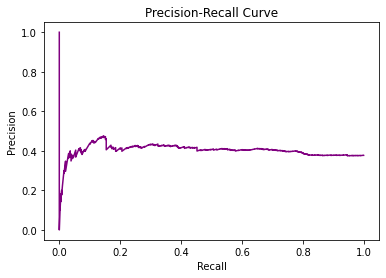

11: Out-of-bag score estimate: 0.62
11: Mean accuracy score: 0.617
11: Recall: 0.0644


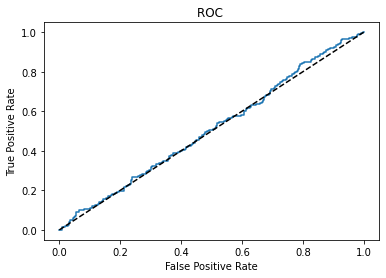

len: 1030


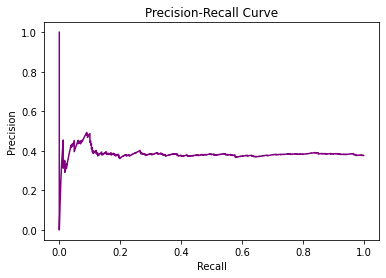

16: Out-of-bag score estimate: 0.608
16: Mean accuracy score: 0.608
16: Recall: 0.0518


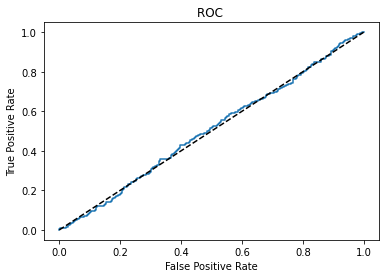

len: 1022


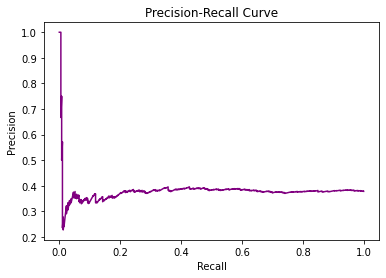

21: Out-of-bag score estimate: 0.58
21: Mean accuracy score: 0.584
21: Recall: 0.0836


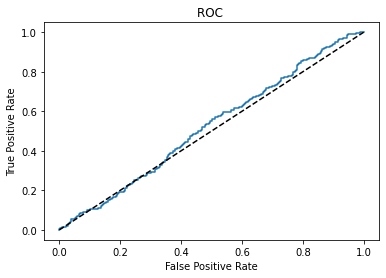

len: 908


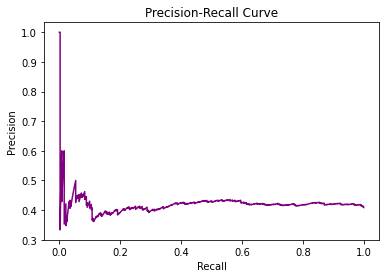

26: Out-of-bag score estimate: 0.524
26: Mean accuracy score: 0.491
26: Recall: 0.302


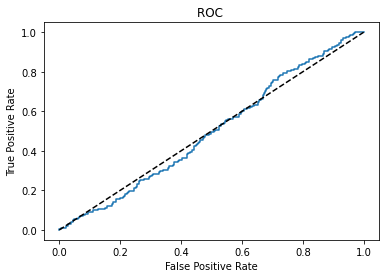

len: 694


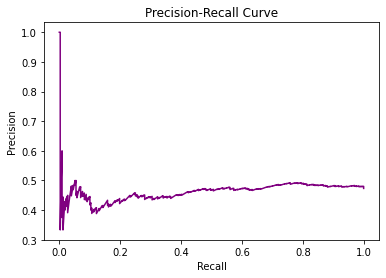

31: Out-of-bag score estimate: 0.546
31: Mean accuracy score: 0.536
31: Recall: 0.65


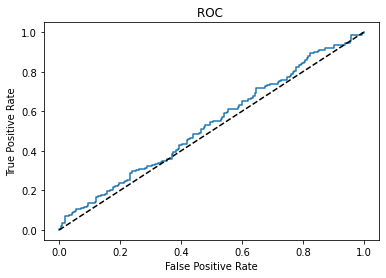

len: 445


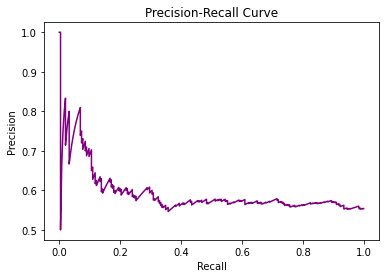

36: Out-of-bag score estimate: 0.633
36: Mean accuracy score: 0.637
36: Recall: 0.86


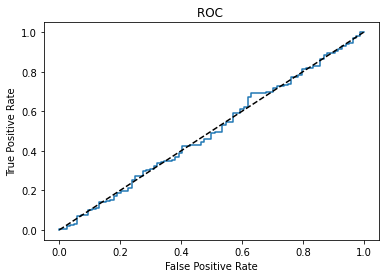

len: 271


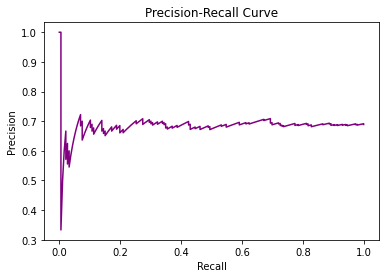

41: Out-of-bag score estimate: 0.719
41: Mean accuracy score: 0.801
41: Recall: 0.97


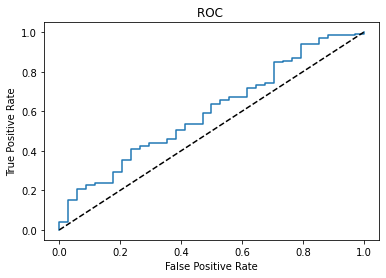

len: 167


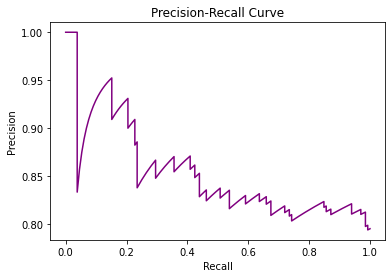

46: Out-of-bag score estimate: 0.765
46: Mean accuracy score: 0.832
46: Recall: 0.967


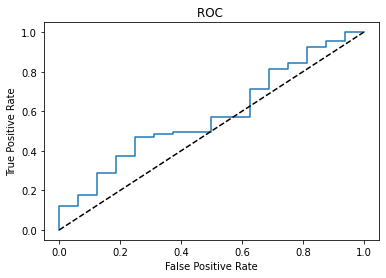

len: 108


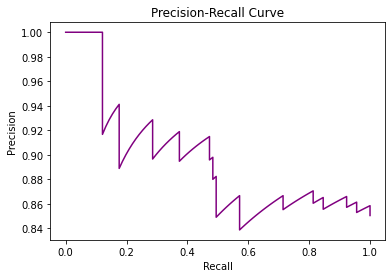

51: Out-of-bag score estimate: 0.8
51: Mean accuracy score: 0.885
51: Recall: 0.982


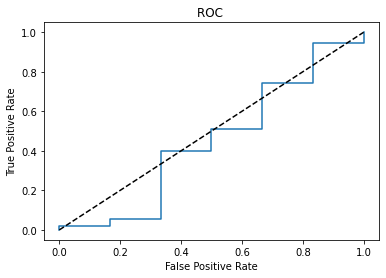

len: 62


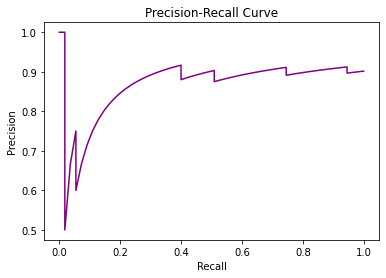

56: Out-of-bag score estimate: 0.764
56: Mean accuracy score: 0.857
56: Recall: 1.0


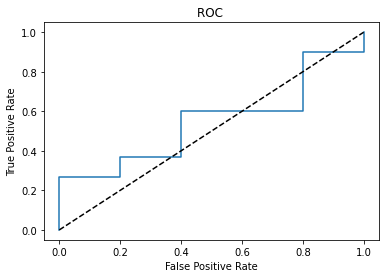

len: 36


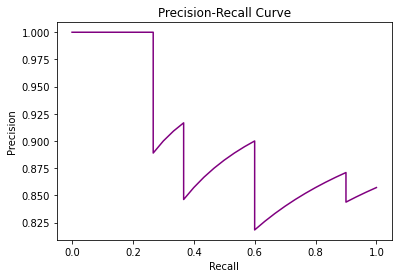

In [14]:
evaluate(clean_test_df_dict_force_simple, models_force_simple)

1: Out-of-bag score estimate: 0.619
1: Mean accuracy score: 0.617
1: Recall: 0.0746


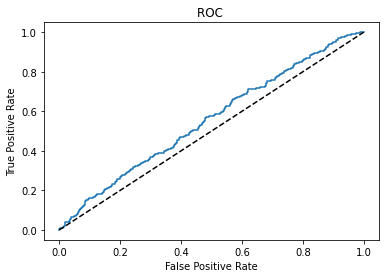

len: 1032


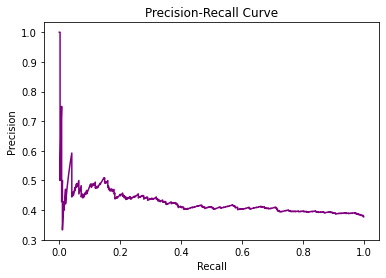

6: Out-of-bag score estimate: 0.617
6: Mean accuracy score: 0.623
6: Recall: 0.103


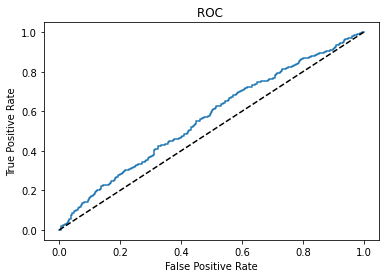

len: 1032


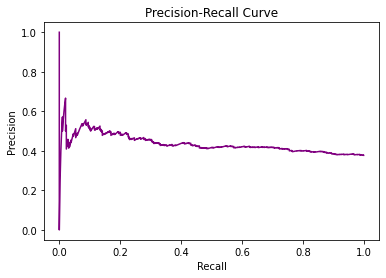

11: Out-of-bag score estimate: 0.618
11: Mean accuracy score: 0.614
11: Recall: 0.049


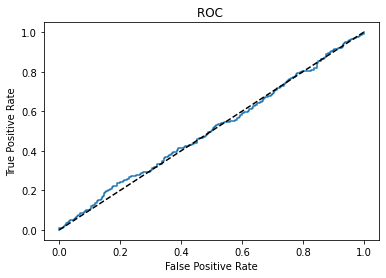

len: 1030


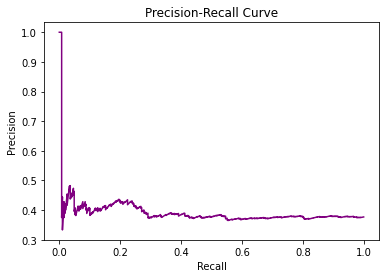

16: Out-of-bag score estimate: 0.616
16: Mean accuracy score: 0.616
16: Recall: 0.0699


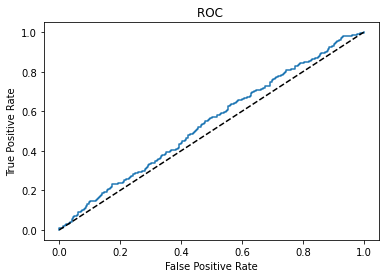

len: 1022


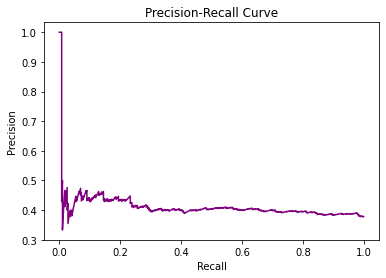

21: Out-of-bag score estimate: 0.619
21: Mean accuracy score: 0.61
21: Recall: 0.261


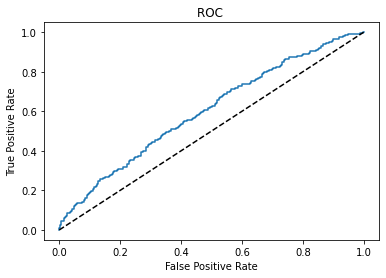

len: 908


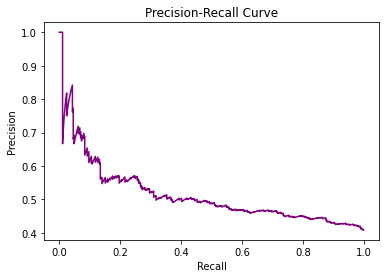

26: Out-of-bag score estimate: 0.628
26: Mean accuracy score: 0.618
26: Recall: 0.485


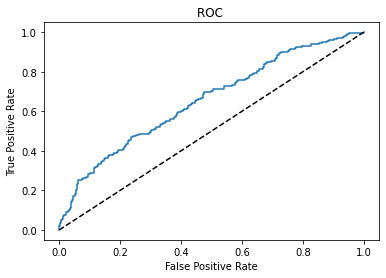

len: 694


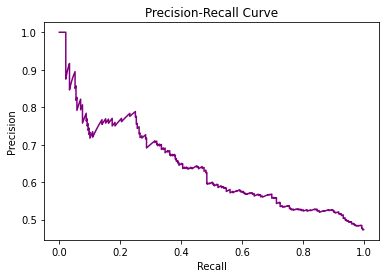

31: Out-of-bag score estimate: 0.639
31: Mean accuracy score: 0.633
31: Recall: 0.683


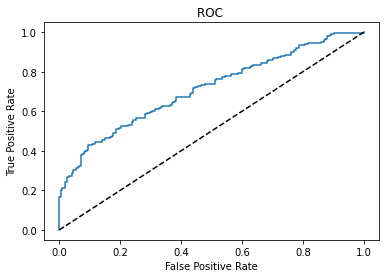

len: 445


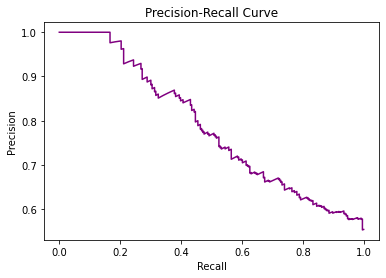

36: Out-of-bag score estimate: 0.683
36: Mean accuracy score: 0.7
36: Recall: 0.849


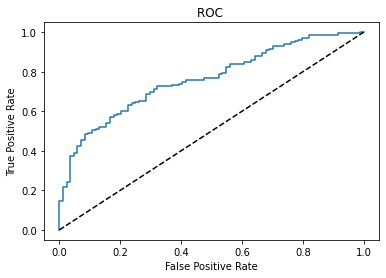

len: 270


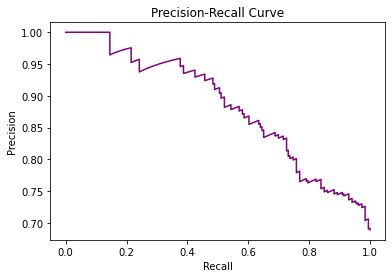

41: Out-of-bag score estimate: 0.739
41: Mean accuracy score: 0.753
41: Recall: 0.879


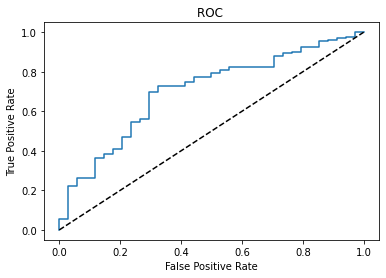

len: 166


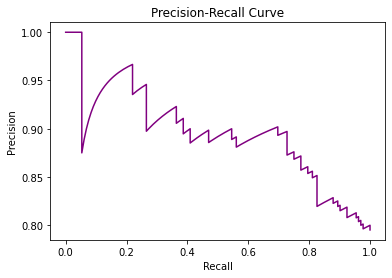

46: Out-of-bag score estimate: 0.784
46: Mean accuracy score: 0.841
46: Recall: 0.945


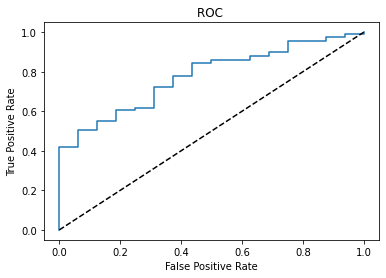

len: 103


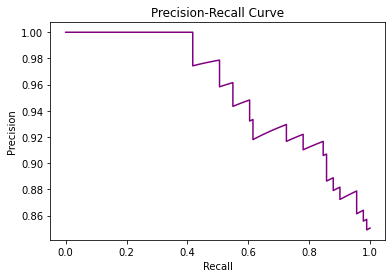

51: Out-of-bag score estimate: 0.81
51: Mean accuracy score: 0.885
51: Recall: 0.964


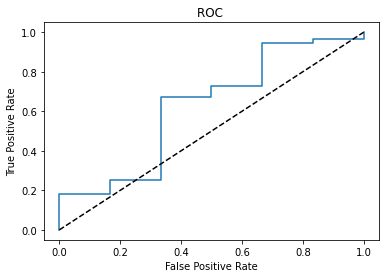

len: 62


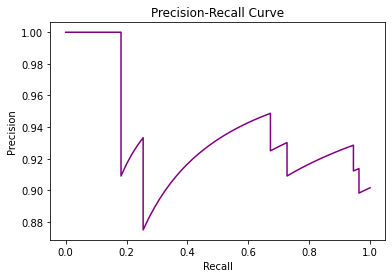

56: Out-of-bag score estimate: 0.791
56: Mean accuracy score: 0.829
56: Recall: 0.933


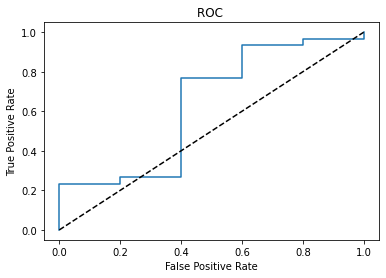

len: 36


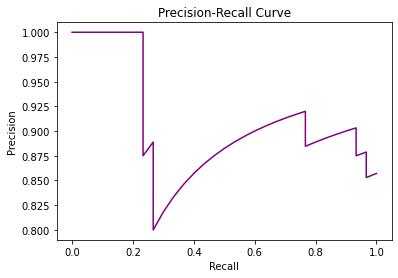

In [25]:
p1, r1 = evaluate(clean_test_df_dict_dist, models_force_dist)

1: Out-of-bag score estimate: 0.613
1: Mean accuracy score: 0.618
1: Recall: 0.0514


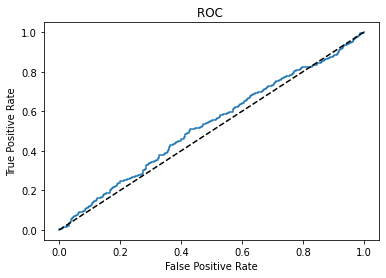

len: 1032


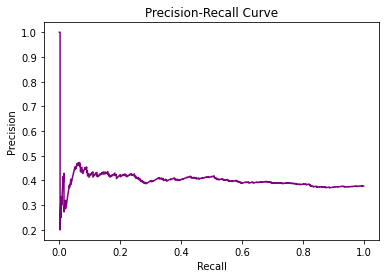

6: Out-of-bag score estimate: 0.61
6: Mean accuracy score: 0.611
6: Recall: 0.0386


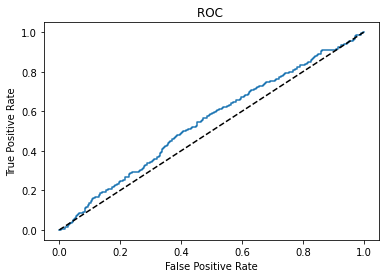

len: 1032


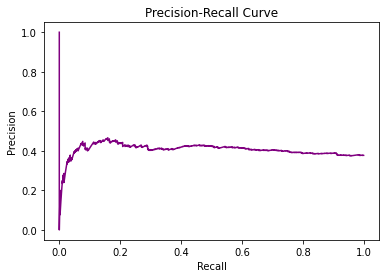

11: Out-of-bag score estimate: 0.615
11: Mean accuracy score: 0.609
11: Recall: 0.0619


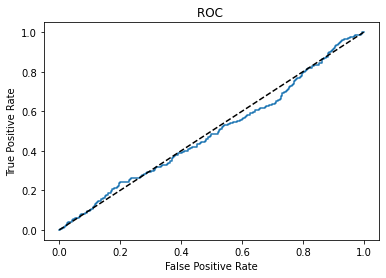

len: 1030


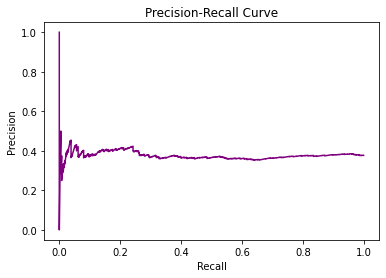

16: Out-of-bag score estimate: 0.608
16: Mean accuracy score: 0.617
16: Recall: 0.0803


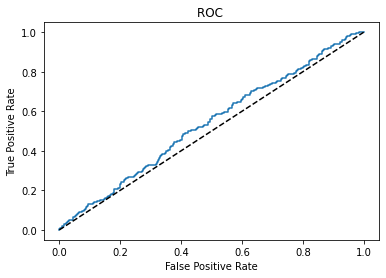

len: 1022


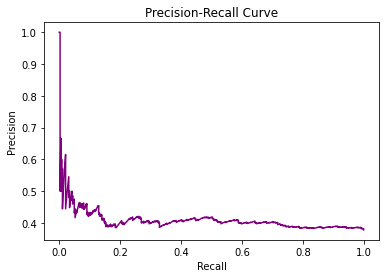

21: Out-of-bag score estimate: 0.575
21: Mean accuracy score: 0.578
21: Recall: 0.0728


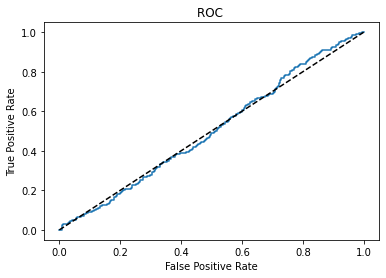

len: 908


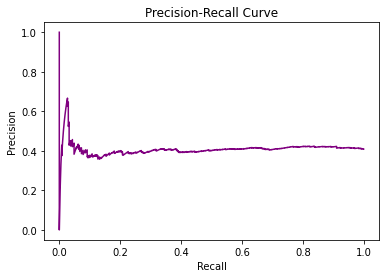

26: Out-of-bag score estimate: 0.54
26: Mean accuracy score: 0.527
26: Recall: 0.338


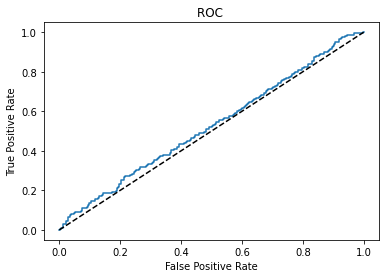

len: 694


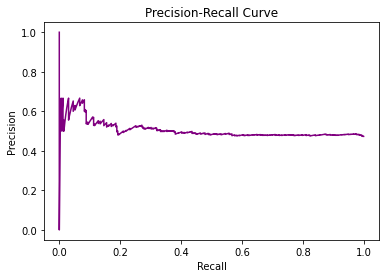

31: Out-of-bag score estimate: 0.572
31: Mean accuracy score: 0.538
31: Recall: 0.638


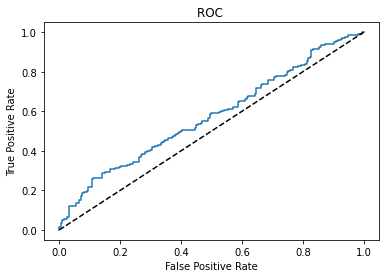

len: 445


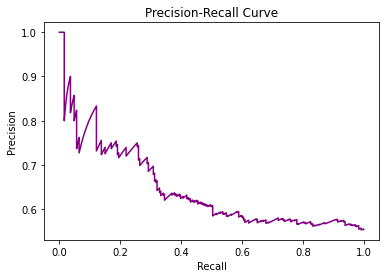

36: Out-of-bag score estimate: 0.634
36: Mean accuracy score: 0.611
36: Recall: 0.806


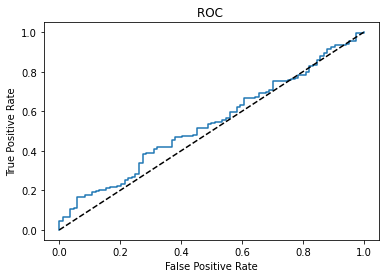

len: 271


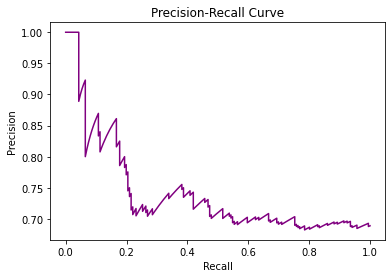

41: Out-of-bag score estimate: 0.715
41: Mean accuracy score: 0.795
41: Recall: 0.97


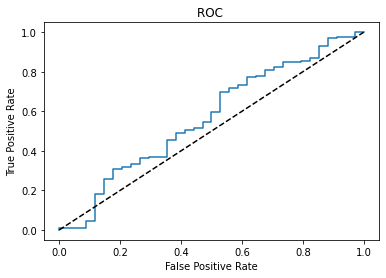

len: 167


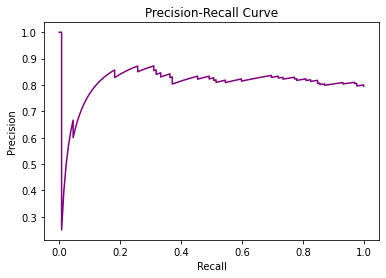

46: Out-of-bag score estimate: 0.768
46: Mean accuracy score: 0.813
46: Recall: 0.945


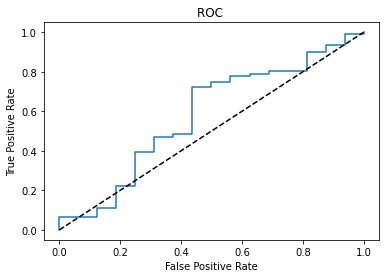

len: 108


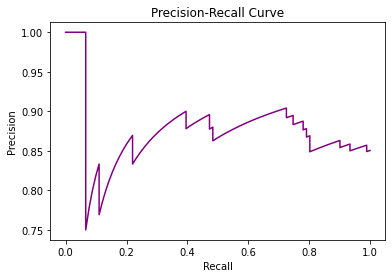

51: Out-of-bag score estimate: 0.79
51: Mean accuracy score: 0.869
51: Recall: 0.964


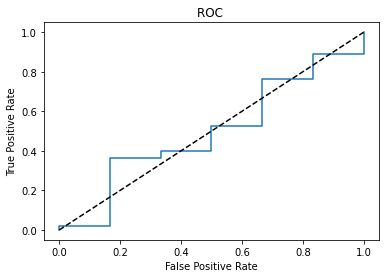

len: 61


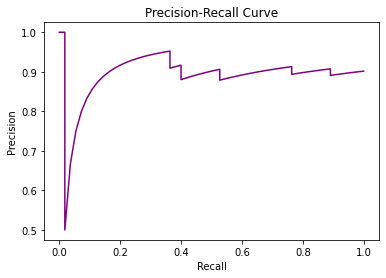

56: Out-of-bag score estimate: 0.759
56: Mean accuracy score: 0.857
56: Recall: 1.0


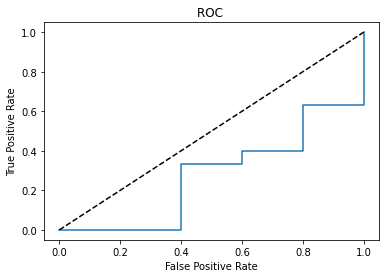

len: 35


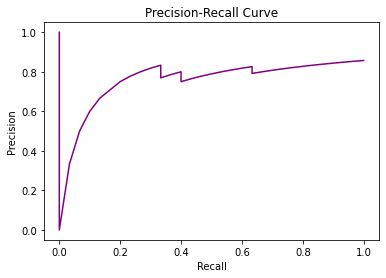

In [16]:
evaluate(clean_test_df_dict_force_weighted, models_force_weighted)

1: Out-of-bag score estimate: 0.616
1: Mean accuracy score: 0.609
1: Recall: 0.0437


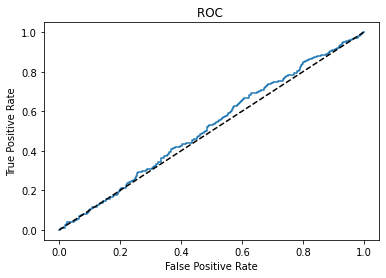

len: 1032


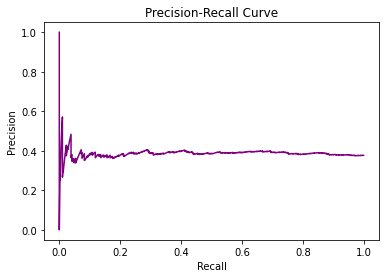

6: Out-of-bag score estimate: 0.614
6: Mean accuracy score: 0.624
6: Recall: 0.147


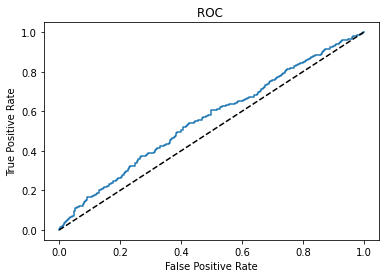

len: 1032


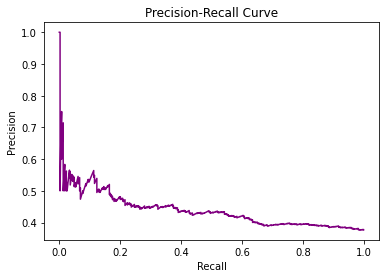

11: Out-of-bag score estimate: 0.614
11: Mean accuracy score: 0.626
11: Recall: 0.121


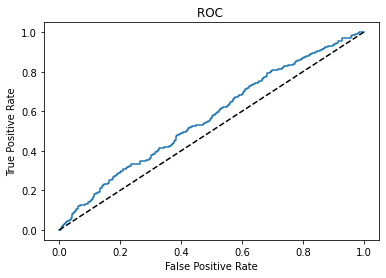

len: 1030


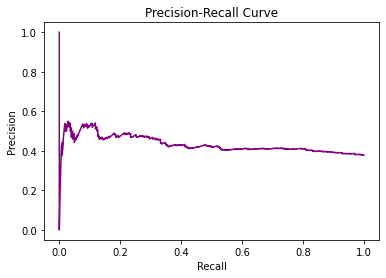

16: Out-of-bag score estimate: 0.615
16: Mean accuracy score: 0.623
16: Recall: 0.127


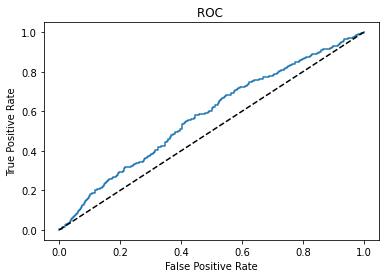

len: 1022


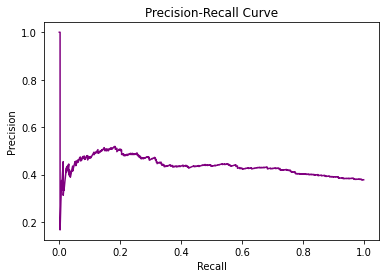

21: Out-of-bag score estimate: 0.595
21: Mean accuracy score: 0.58
21: Recall: 0.173


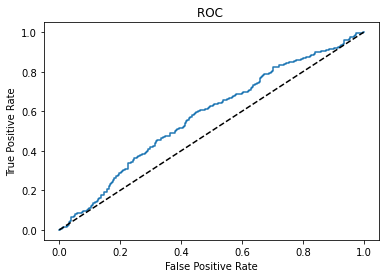

len: 908


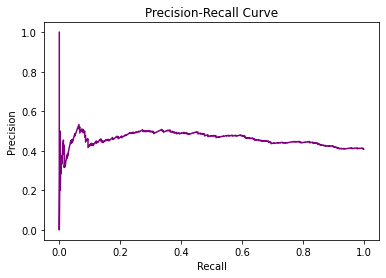

26: Out-of-bag score estimate: 0.557
26: Mean accuracy score: 0.59
26: Recall: 0.476


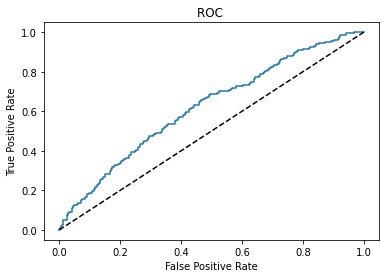

len: 694


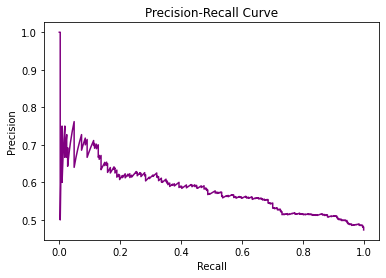

31: Out-of-bag score estimate: 0.578
31: Mean accuracy score: 0.583
31: Recall: 0.646


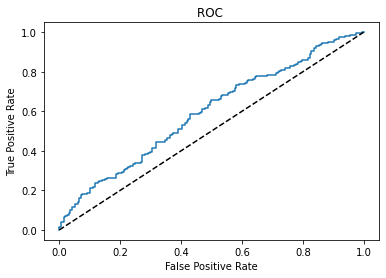

len: 445


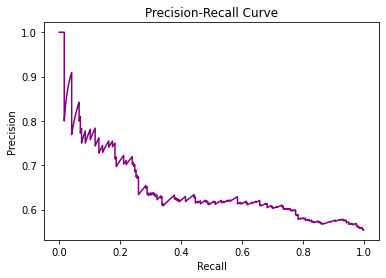

36: Out-of-bag score estimate: 0.628
36: Mean accuracy score: 0.689
36: Recall: 0.876


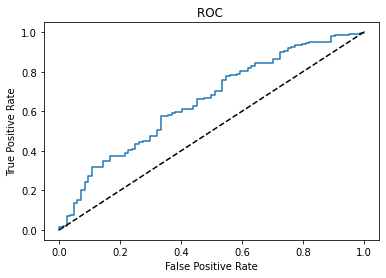

len: 271


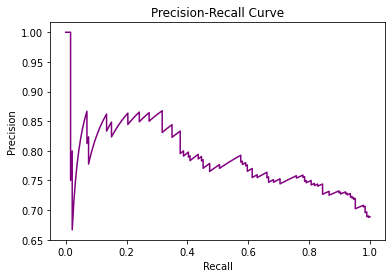

41: Out-of-bag score estimate: 0.711
41: Mean accuracy score: 0.807
41: Recall: 0.955


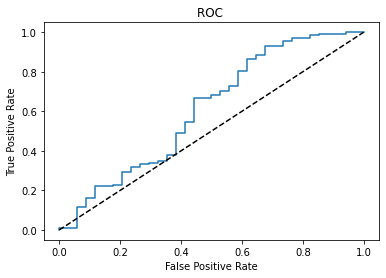

len: 167


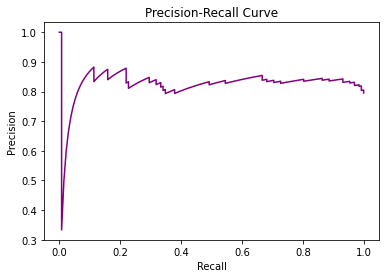

46: Out-of-bag score estimate: 0.763
46: Mean accuracy score: 0.832
46: Recall: 0.945


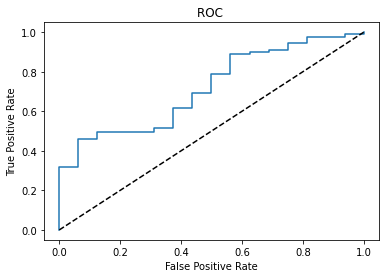

len: 108


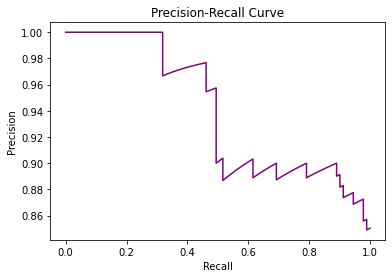

51: Out-of-bag score estimate: 0.795
51: Mean accuracy score: 0.869
51: Recall: 0.964


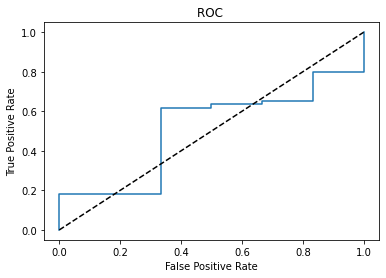

len: 62


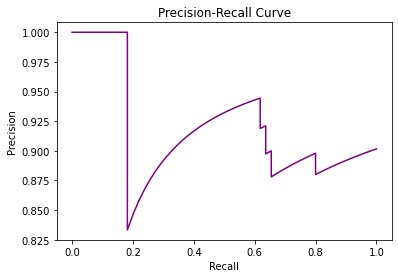

56: Out-of-bag score estimate: 0.757
56: Mean accuracy score: 0.829
56: Recall: 0.967


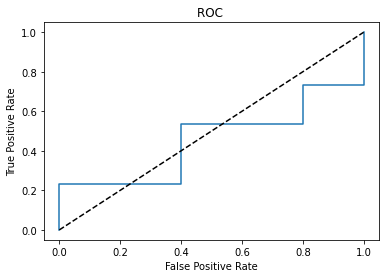

len: 36


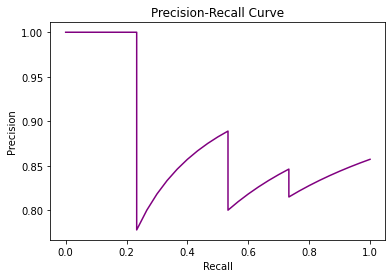

In [17]:
evaluate(clean_test_df_dict_force_partitioned, models_force_partitioned)

1: Out-of-bag score estimate: 0.618
1: Mean accuracy score: 0.626
1: Recall: 0.072


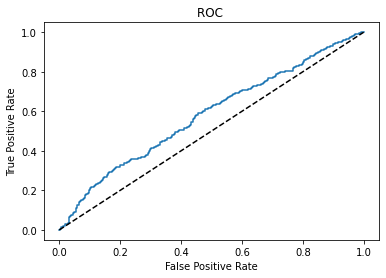

len: 1032


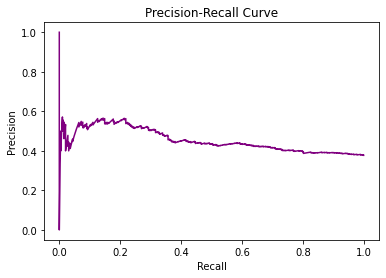

6: Out-of-bag score estimate: 0.624
6: Mean accuracy score: 0.629
6: Recall: 0.1


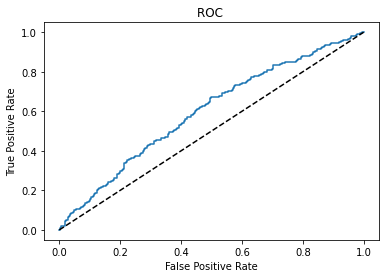

len: 1032


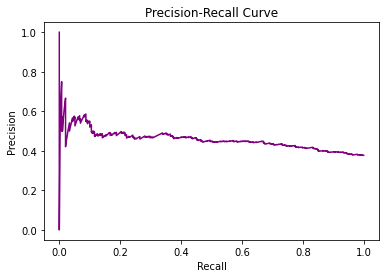

11: Out-of-bag score estimate: 0.621
11: Mean accuracy score: 0.619
11: Recall: 0.0773


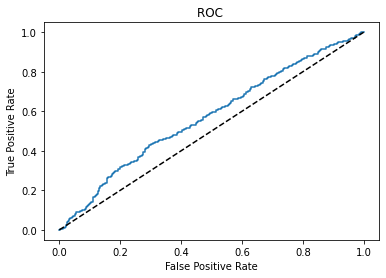

len: 1030


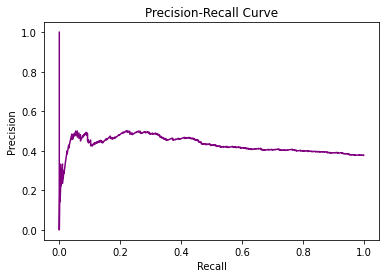

16: Out-of-bag score estimate: 0.621
16: Mean accuracy score: 0.619
16: Recall: 0.0803


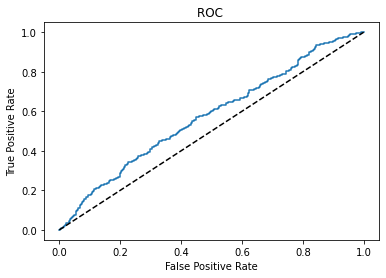

len: 1022


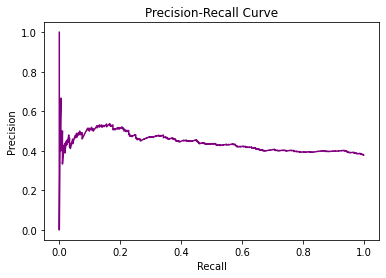

21: Out-of-bag score estimate: 0.618
21: Mean accuracy score: 0.602
21: Recall: 0.181


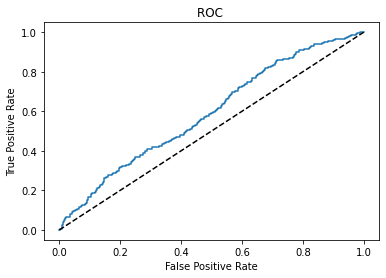

len: 908


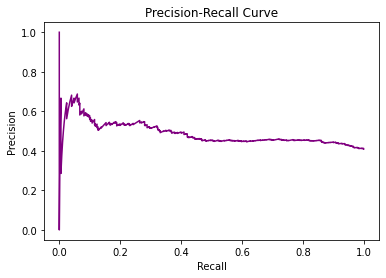

26: Out-of-bag score estimate: 0.623
26: Mean accuracy score: 0.603
26: Recall: 0.451


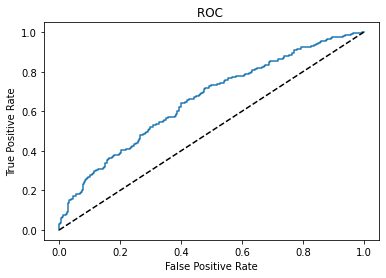

len: 694


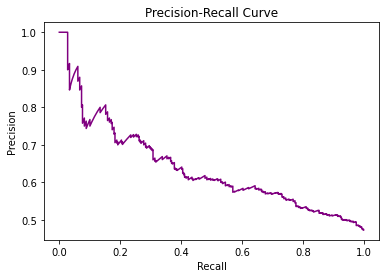

31: Out-of-bag score estimate: 0.659
31: Mean accuracy score: 0.658
31: Recall: 0.732


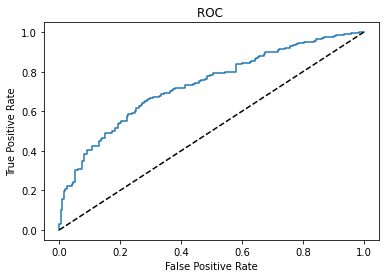

len: 445


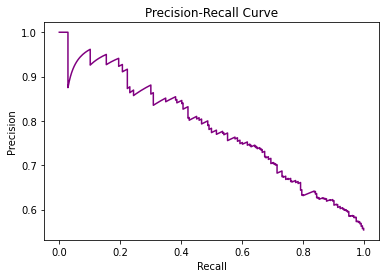

36: Out-of-bag score estimate: 0.694
36: Mean accuracy score: 0.707
36: Recall: 0.86


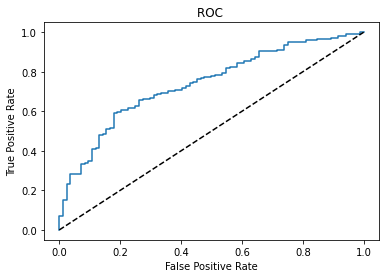

len: 271


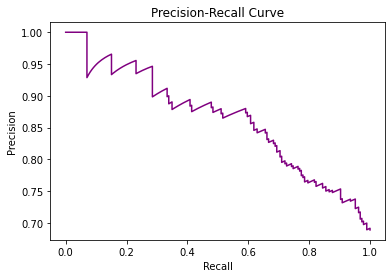

41: Out-of-bag score estimate: 0.747
41: Mean accuracy score: 0.831
41: Recall: 0.97


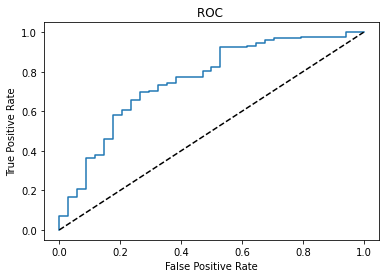

len: 167


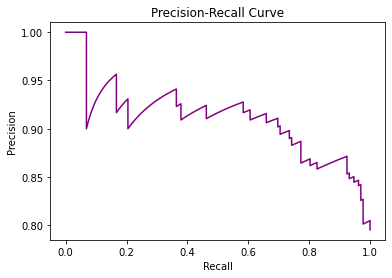

46: Out-of-bag score estimate: 0.786
46: Mean accuracy score: 0.86
46: Recall: 0.967


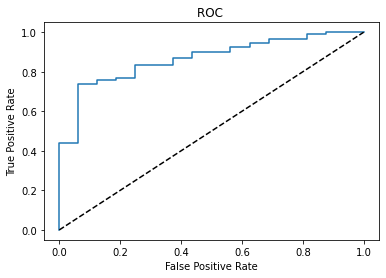

len: 108


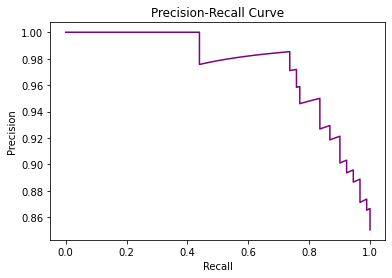

51: Out-of-bag score estimate: 0.816
51: Mean accuracy score: 0.902
51: Recall: 1.0


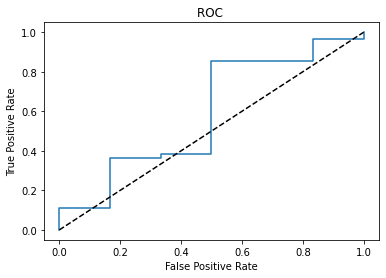

len: 62


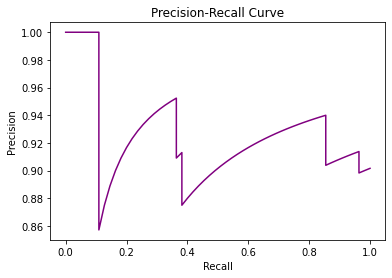

56: Out-of-bag score estimate: 0.789
56: Mean accuracy score: 0.829
56: Recall: 0.967


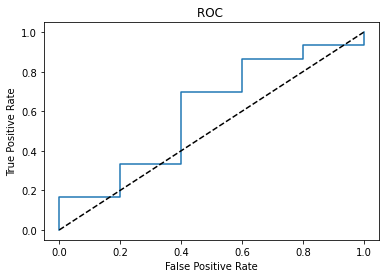

len: 36


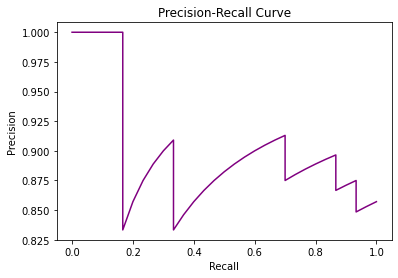

In [26]:
p2, r2 = evaluate(clean_test_df_dict_all, models_all)

1: Out-of-bag score estimate: 0.616
1: Mean accuracy score: 0.625
1: Recall: 0.0694


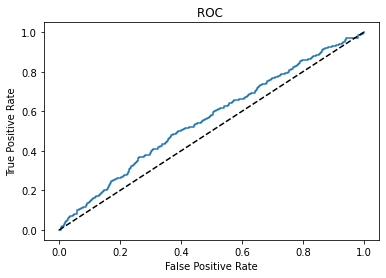

len: 1032


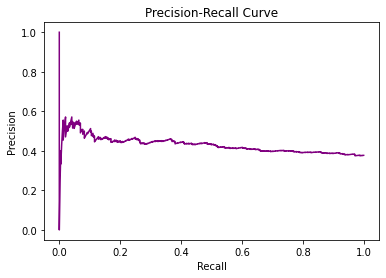

6: Out-of-bag score estimate: 0.618
6: Mean accuracy score: 0.617
6: Recall: 0.105


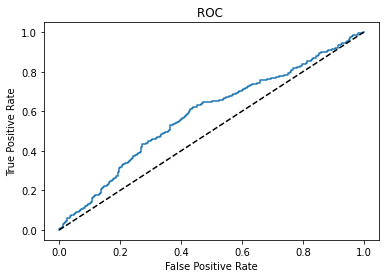

len: 1032


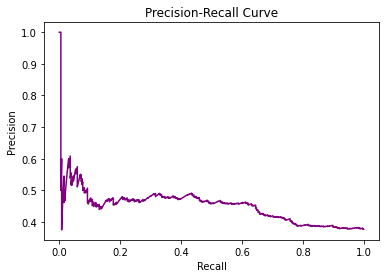

11: Out-of-bag score estimate: 0.617
11: Mean accuracy score: 0.62
11: Recall: 0.103


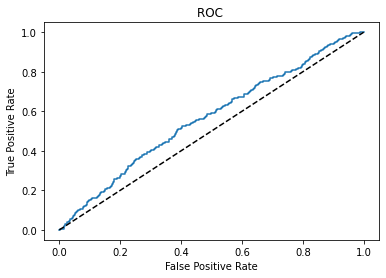

len: 1030


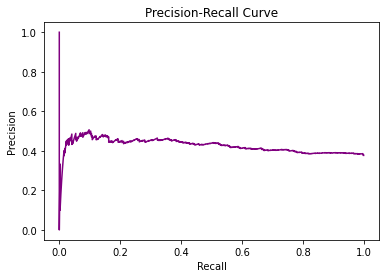

16: Out-of-bag score estimate: 0.612
16: Mean accuracy score: 0.625
16: Recall: 0.13


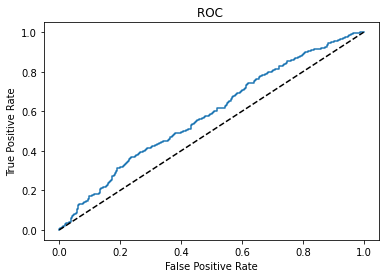

len: 1022


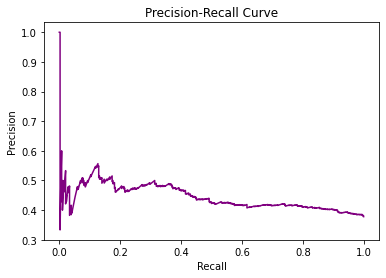

21: Out-of-bag score estimate: 0.598
21: Mean accuracy score: 0.585
21: Recall: 0.146


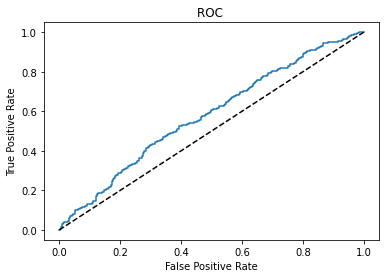

len: 908


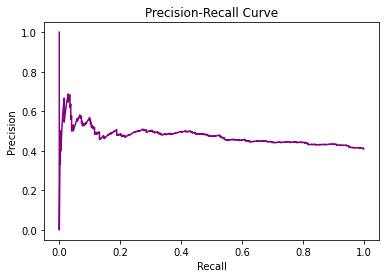

26: Out-of-bag score estimate: 0.586
26: Mean accuracy score: 0.58
26: Recall: 0.439


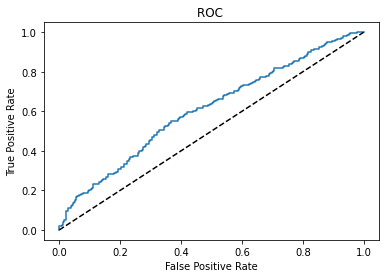

len: 694


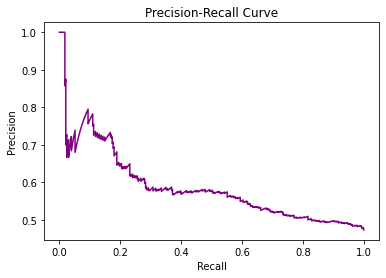

31: Out-of-bag score estimate: 0.624
31: Mean accuracy score: 0.615
31: Recall: 0.691


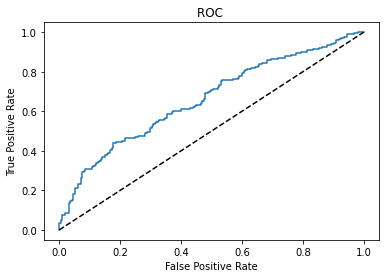

len: 445


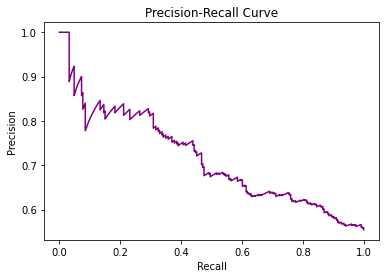

36: Out-of-bag score estimate: 0.662
36: Mean accuracy score: 0.67
36: Recall: 0.833


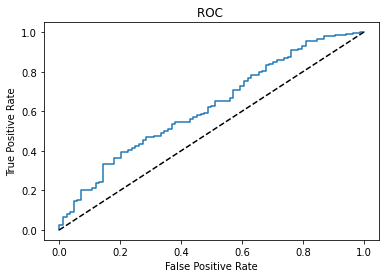

len: 271


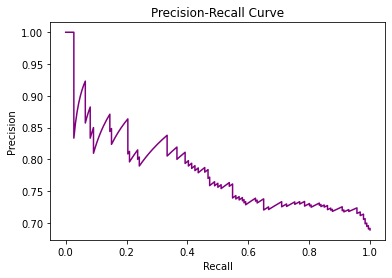

41: Out-of-bag score estimate: 0.726
41: Mean accuracy score: 0.807
41: Recall: 0.962


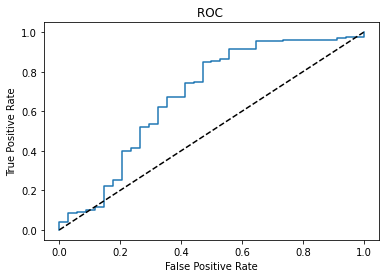

len: 167


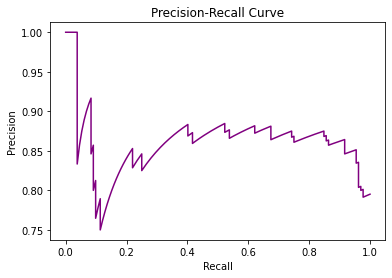

46: Out-of-bag score estimate: 0.783
46: Mean accuracy score: 0.869
46: Recall: 0.978


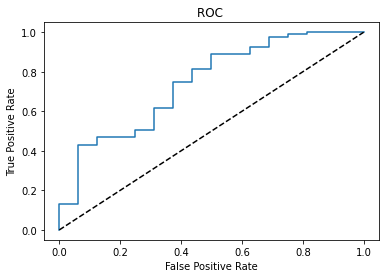

len: 108


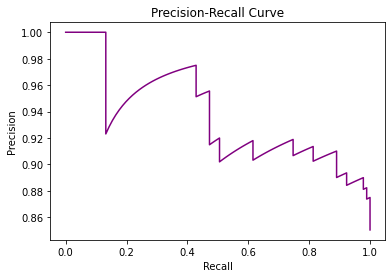

51: Out-of-bag score estimate: 0.805
51: Mean accuracy score: 0.885
51: Recall: 0.982


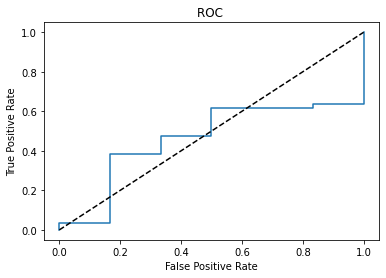

len: 61


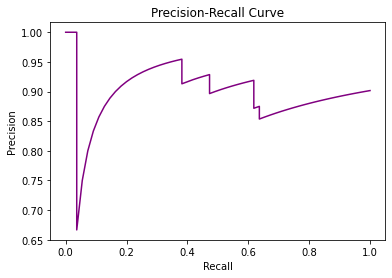

56: Out-of-bag score estimate: 0.771
56: Mean accuracy score: 0.857
56: Recall: 1.0


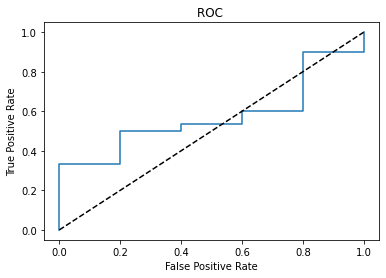

len: 34


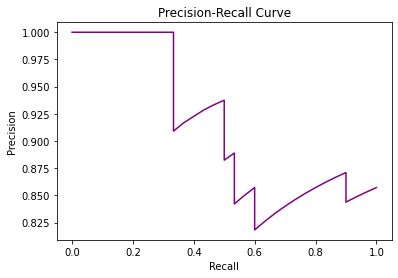

In [27]:
p3, r3 = evaluate(clean_test_df_dict_force_all, models_force_all)

In [31]:
# 1, 2, 3 is dist, all, forces all
df = pd.DataFrame()
df['precision_dist'] = p1
df['recall_dist'] = r1
df['precision_forces'] = p3
df['recall_forces'] = r3
df['precision_all'] = p2
df['recall_all'] = r2
df.to_csv('results.csv', index = False)